# RNN with injected variables
---
Here we would like to feed PYTHIA data into a Recurrent Neural Network (RNN) in order to classify between Z processes and the background QCD processes. 

In [1]:
# TensorFlow and tf.keras

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import models
# import tensorflow.keras.utils
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils



# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Load in the data from the file "Constituent4vecDataTest.npz" and format it to properly have the network analyze it. (Inputs have to be the same size).

The data is a number of jet events, and within each event, the top 20 particles are selected for the dataset. 

In [2]:
data = np.load('/mnt/data/ml/Constituent4vec_addgroomedtau.npz')

pt = data['jetconstPt_log']
eta = data['delta_eta']
phi = data['delta_phi']
labels = data['labels']
tau21 = data['tau21']
chMult = data['isCh']

#fix values outside jet
#eta[eta < -0.8] = 0
#eta[eta > 0.8] = 0
#phi[phi < -0.8] = 0
#phi[phi > 0.8] = 0


labels = labels[::20]
tau21 = tau21[::20]
chMult = np.sum(chMult, axis = 1)


In [3]:
fourvec = np.stack((pt,eta,phi), axis = -1)

qcd_vec = fourvec[np.where(labels[:,0] == 1)]
qcd_tau = tau21[np.where(labels[:,0] == 1)]
qcd_mult = chMult[np.where(labels[:,0] == 1)]

z_vec = fourvec[np.where(labels[:,1] == 1)]
z_tau = tau21[np.where(labels[:,1] == 1)]
z_mult = chMult[np.where(labels[:,1] == 1)]

#ensure same number of signal vs. background
qcd_vec = qcd_vec[:len(z_vec)]
qcd_tau = qcd_tau[:len(z_tau)]
qcd_mult = qcd_mult[:len(z_mult)]

In [4]:
qcd_vec = qcd_vec[::10]
qcd_tau = qcd_tau[::10]
qcd_mult = qcd_mult[::10]

z_vec = z_vec[::10]
z_tau = z_tau[::10]
z_mult = z_mult[::10]


In [5]:
qcd_lab = np.zeros([len(qcd_vec), 2])
qcd_lab[:,0] = 1
z_lab = np.zeros([len(qcd_vec), 2])
z_lab[:,1] = 1


fourvec = np.vstack((qcd_vec, z_vec))
taus = np.hstack((qcd_tau, z_tau))
mults = np.hstack((qcd_mult, z_mult))
labels = np.vstack((qcd_lab, z_lab))
print(len(labels), len(fourvec))

176556 176556


In [6]:
n_data = len(fourvec)
testvec = fourvec[::4]
testlabels = labels[::4]
testtaus = taus[::4]
testmults = mults[::4]

mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
mask_tau = np.ones(taus.shape,dtype=bool)
mask_tau[::4] = 0
mask_tau[1::8] = 0
mask_mult = np.ones(mults.shape,dtype=bool)
mask_mult[::4] = 0
mask_mult[1::8] = 0

valvec = fourvec[1::8]
vallabels = labels[1::8]
valtaus = taus[1::8]
valmults = mults[1::8]

train_len = (n_data-len(testvec)-len(valvec))

trainvec = fourvec[mask_vec].reshape(train_len,20,3)
trainlabels = labels[mask_lab].reshape(train_len, 2)
traintaus = taus[mask_tau].reshape(train_len, 1)
trainmults = mults[mask_mult].reshape(train_len, 1)

Now to construct the network itself.

We start out with the four-vector data (pt, eta, phi) being fed into our RNN layers (GRU). After a sequence of RNN layers, we add the injected variables (tau21 and charge multiplicity). 

In [7]:
def build_model():
    
    input1 = layers.Input(shape = (20,3))

#    x = layers.Dense(64, activation='relu', name = 'relu1')(input1)
    x = layers.GRU(4*rnn_units, return_sequences = True, name = 'gru1')(input1)
    x = layers.GRU(4*rnn_units, return_sequences = True, name = 'gru2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GRU(rnn_units, return_sequences = True, name = 'gru3')(x)
    
    xf = layers.Flatten(name = "flatten")(x)
    
    input2 = layers.Input(shape=(1,))
    input3 = layers.Input(shape=(1,))
    
    x = layers.concatenate(inputs = [xf, input2, input3],axis=-1)
    
    x = layers.Dense(256, activation= 'relu', name = 'dense1')(x)
    

    output = layers.Dense(2, activation='softmax', name = 'output')(x)

    model = models.Model(inputs= [input1, input2, input3], outputs=output)
    
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [8]:
rnn_units = 32


batch = 20

RNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


The network is run over a test batch of data to verify its working.

In [9]:
example_batch = trainvec[::300]
example_labels = trainlabels[::300]
example_taus = traintaus[::300]
example_mults = trainmults[::300]

example_result = RNN.predict(x = [example_batch, example_taus, example_mults])
results = RNN.evaluate(x = [example_batch, example_taus, example_mults], y = example_labels)


print(example_result)
print(results)

368/368 [==============================] - 0s 1ms/step
[[0.68596184 0.31403813]
 [0.67694217 0.32305777]
 [0.727202   0.27279806]
 [0.56391114 0.43608886]
 [0.70054424 0.29945582]
 [0.6500103  0.34998974]
 [0.6529987  0.3470013 ]
 [0.65293425 0.34706575]
 [0.7072938  0.29270622]
 [0.70150644 0.29849353]
 [0.65839756 0.34160236]
 [0.65905285 0.34094715]
 [0.63296    0.36703998]
 [0.6730896  0.32691038]
 [0.7674778  0.23252217]
 [0.6726825  0.32731745]
 [0.725331   0.27466908]
 [0.68803364 0.31196633]
 [0.6733155  0.32668442]
 [0.7253971  0.27460295]
 [0.6338305  0.3661695 ]
 [0.68654644 0.3134536 ]
 [0.74778765 0.25221235]
 [0.6515766  0.34842342]
 [0.68565446 0.31434557]
 [0.6768791  0.3231209 ]
 [0.7096745  0.2903255 ]
 [0.75148714 0.24851288]
 [0.69215244 0.3078476 ]
 [0.697652   0.30234802]
 [0.73874116 0.26125893]
 [0.5879591  0.41204095]
 [0.70961696 0.29038304]
 [0.64550126 0.3544987 ]
 [0.6154623  0.38453776]
 [0.7081589  0.2918411 ]
 [0.7544071  0.24559286]
 [0.6797255  0.32027

Now to actually analyze the data itself. An early stopping function is used to minimize overfitting by ending the network's training when it is no longer significantly improving.

In [10]:
checkpoint_path = "model/RNN.h5"
if not os.path.exists("model"):
    os.mkdir("model")


model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 25
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = RNN.fit(
  [trainvec,traintaus, trainmults], trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.89464, saving model to model/RNN.h5

Epoch 00002: val_loss improved from 0.89464 to 0.73564, saving model to model/RNN.h5

Epoch 00003: val_loss improved from 0.73564 to 0.72046, saving model to model/RNN.h5

Epoch 00004: val_loss improved from 0.72046 to 0.62941, saving model to model/RNN.h5

Epoch 00005: val_loss did not improve from 0.62941

Epoch 00006: val_loss improved from 0.62941 to 0.61189, saving model to model/RNN.h5

Epoch 00007: val_loss did not improve from 0.61189

Epoch 00008: val_loss did not improve from 0.61189

Epoch 00009: val_loss improved from 0.61189 to 0.54039, saving model to model/RNN.h5

Epoch 00010: val_loss did not improve from 0.54039

Epoch 00011: val_loss did not improve from 0.54039

Epoch 00012: val_loss did not improve from 0.54039

Epoch 00013: val_loss did not improve from 0.54039

Epoch 00014: val_loss did not improve from 0.54039


In [11]:
!ls model
best_model = keras.models.load_model('model/RNN.h5')
best_model.summary()
results = best_model.evaluate([testvec, testtaus, testmults],  testlabels, verbose = 0)
print(results)

CNN1D_v3.h5  no_inj_var.h5  RNN.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 3)        0                                            
__________________________________________________________________________________________________
gru1 (GRU)                      (None, 20, 128)      50688       input_1[0][0]                    
__________________________________________________________________________________________________
gru2 (GRU)                      (None, 20, 128)      98688       gru1[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 20, 128)      512         gru2[0][0]                       
__________________________________________________________________________

Now to the test the quality of the network's classification by gicing it the test dataset.

In [12]:
predict = best_model.predict([testvec , testtaus,testmults])

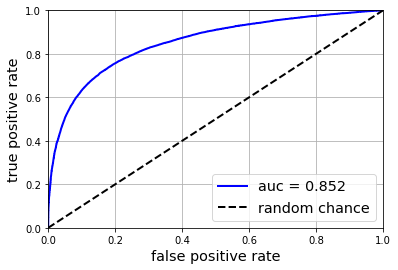

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate', fontsize = 'x-large')
plt.ylabel('true positive rate', fontsize = 'x-large')
#plt.title('ROC curve with injected variables', fontsize = 14)
plt.legend(loc="lower right", fontsize = 'x-large')
plt.grid()
plt.show()

Given that our ROC curve gives a value close to 1 and far from the random guessing curve, we can conclude the network is learning something in order to distinguish between signal and background. Next, we will apply LRP on the network to determine if this is "quality" learning.

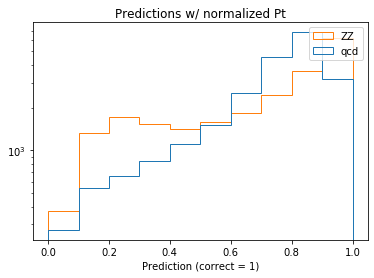

In [14]:
indqcd = np.argwhere(testlabels[:,0] == 1)
indz  = np.argwhere(testlabels[:,1] == 1) 
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[indz, 1].flatten()], histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/ normalized Pt')
plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()